In [2]:
from utils_gfat import lidar,lidarQA
import numpy as np
import matplotlib.pyplot as plt
import lidar_processing.lidar_processing.helper_functions as helper_functions
from utils_gfat import lidar_elastic_retrieval
from scipy import integrate
import utils_gfat.lidar_processing.lidar_processing.raman_retrievals as raman_retrievals
from Src.window_fliter import window_fliter

In [3]:
rs_fl ='./Data/kal_1a_Pfp_rs_xf_20180408.nc'
dc_fl='./Data/kal_1a_Pdc_rs_xf_20200520_1702.nc'
ds = lidar.preprocessing(rs_fl=rs_fl,ini_date= '20180408T202100', end_date='20180408T235900')

INFO: lidar. preprocessing. L456: Start Lidar Preprocessing ...
INFO: lidar. preprocessing. L459: Read Raw Signal
INFO: lidar. reader_xarray. L264: Start Reader ...
INFO: lidar. reader_xarray. L276: ['./Data/kal_1a_Pfp_rs_xf_20180408.nc']
INFO: lidar. check_minimum_profiles. L230: Data loaded from 20180408T202100 to 20180408T235900
INFO: lidar. reader_xarray. L369: End Reader
INFO: lidar. preprocessing. L533: Channel 355xpa
INFO. Start Get Bin Zero
Error. File ..\LIDAR\1a\bin_zero.csv not found
INFO. End Get Bin Zero
Start Analog Preprocessing
Start Estimate Background
End Estimate Background
End Analog Preprocessing
INFO: lidar. preprocessing. L533: Channel 355xpp
INFO. Start Get Bin Zero
Error. File ..\LIDAR\1a\bin_zero.csv not found
INFO. End Get Bin Zero
INFO. Start Get Dead Time
File not found ..\LIDAR\1a\dead_time.csv
dead time set to default:  3.704 (ns)
INFO. End Get Dead Time
Start Estimate Background
End Estimate Background
INFO: lidar. preprocessing. L533: Channel 355xsa
INF

In [4]:
ds

<xarray.Dataset>
Dimensions:              (time: 154, range: 2666, channel: 6)
Coordinates:
  * time                 (time) datetime64[ns] 2018-04-08T20:21:27 ... 2018-0...
  * range                (range) float32 7.5 15.0 22.5 ... 1.999e+04 2e+04
  * channel              (channel) object '355xpa' '355xpp' ... '387xtp'
Data variables: (12/31)
    lat                  float32 ...
    lon                  float32 ...
    altitude             float32 ...
    zenith_angle         (time) float32 dask.array<chunksize=(154,), meta=np.ndarray>
    azimuth_angle        (time) float32 dask.array<chunksize=(154,), meta=np.ndarray>
    time_resol           float32 ...
    ...                   ...
    bin_zero             (channel) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    dead_time            (channel) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    signal_355xta        (time, range) float64 dask.array<chunksize=(154, 2666), meta=np.ndarray>
    lvd_355xa            (time, range) float64 dask.array<chunksize=(154, 2666), meta=np.ndarray>
    signal_355xtp        (time, range) float64 dask.array<chunksize=(154, 2666), meta=np.ndarray>
    lvd_355xp            (time, range) float64 dask.array<chunksize=(154, 2666), meta=np.ndarray>
Attributes: (12/74)
    system:                          KASCAL
    manufacturers:                   Raymetrics
    overlap_is_corrected:            false
    overlap_function:                false
    site_location:                   Karlsruhe, Germany, mobile
    instrument_id:                   KASCAL
    ...                              ...
    telescope1_manufacturer:         Raymetrics
    telescope1_diameter:             special
    BCK_MIN_ALT:                     45000
    BCK_MAX_ALT:                     60000
    lidarNick:                       kal
    dataversion:                     1a

In [5]:
dsd = {'ver':[], 'sla':[]}
dsd['ver'] = ds.sel(time=ds.time[ds.zenith_angle.values==-90]) 
dsd['sla'] = ds.sel(time=ds.time[ds.zenith_angle.values==-30]) 
dsd['ver'] = dsd['ver'].assign_coords({'range':(dsd['ver'].range)})
dsd['sla'] = dsd['sla'].assign_coords({'range':((dsd['sla'].range)/2)})

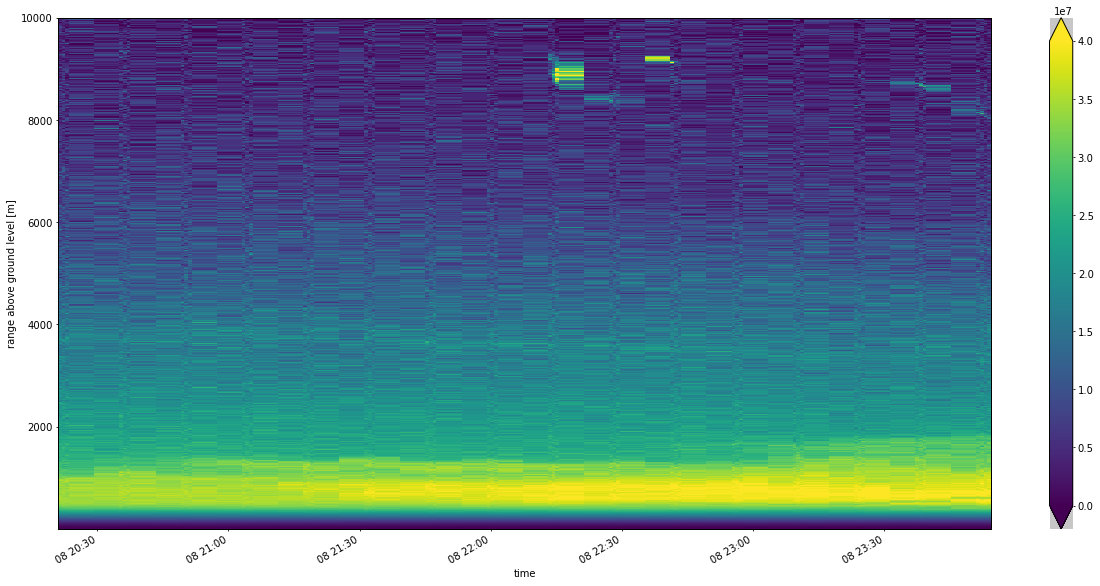

In [6]:
fig, ax = plt.subplots(figsize=[20,10])
(dsd['ver'].signal_355xpp.sel(range=slice(0, 10000))*(dsd['ver'].range**2)).T.plot(ax=ax,vmin=0,vmax=4e7)

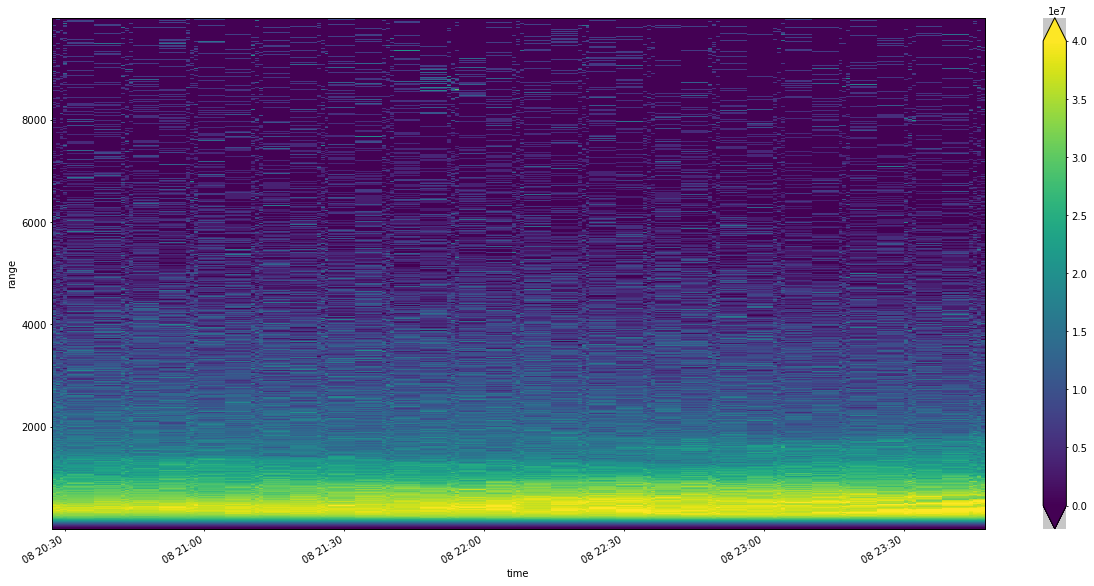

In [7]:
fig, ax = plt.subplots(figsize=[20,10])
(dsd['sla'].signal_355xpp.sel(range=slice(0, 10000))*((dsd['sla'].range*2)**2)).T.plot(ax=ax,vmin=0,vmax=4e7)

In [8]:
# get the profile of molecule 
height = dsd['ver'].range.values
temperature_prf= {'ver':[], 'sla':[]}
pressure_prf = {'ver':[], 'sla':[]}

temperature_prf_v = np.ones(height.size)*np.nan
pressure_prf_v = np.ones(height.size)*np.nan
molpd = {'ver':[], 'sla':[]}
for i, _height in enumerate(height):
    sa = helper_functions.standard_atmosphere(_height+119)
    pressure_prf_v[i] = sa[0]
    temperature_prf_v[i] = sa[1]
molpd['ver'] = lidarQA.molecular_properties(355, pressure_prf_v,temperature_prf_v,height)
temperature_prf['ver'] = temperature_prf_v
pressure_prf['ver'] = pressure_prf_v

temperature_prf_s = np.ones(height.size)*np.nan
pressure_prf_s = np.ones(height.size)*np.nan
for i, _height in enumerate(height):
    sa = helper_functions.standard_atmosphere(_height/2+119)
    pressure_prf_s[i] = sa[0]
    temperature_prf_s[i] = sa[1]
molpd['sla'] = lidarQA.molecular_properties(355, pressure_prf_s,temperature_prf_s,height)
temperature_prf['sla'] = temperature_prf_s
pressure_prf['sla'] = pressure_prf_s

In [32]:
#%% Fernald
rcs_355xpp_v = dsd['ver'].signal_355xpp.mean('time')*dsd['ver'].range**2
rcs_355xpa_v = dsd['ver'].signal_355xpa.mean('time')*dsd['ver'].range**2
rcs_355xpp_s = dsd['sla'].signal_355xpp.mean('time')*(dsd['sla'].range*2)**2
beta_part = {'ver':[], 'sla':[]}
att_beta_total = {'ver':[], 'sla':[]}
lr_aer = 55
resolution = height[1] - height[0]
lr_mol = molpd['ver'].molecular_lidar_ratio.values
molbeta = {'ver':[], 'sla':[]}
alpha_mol= {'ver':[], 'sla':[]}

molbeta['ver'] = molpd['ver']['molecular_beta'].values
alpha_mol['ver'] = molpd['ver']['molecular_alpha'].values

molbeta['sla'] = molpd['sla']['molecular_beta'].values
alpha_mol['sla'] = molpd['sla']['molecular_alpha'].values

constant = 3.7e-6
beta_part['ver'] = lidar_elastic_retrieval.klett(rcs_355xpp_v.values, height, molbeta['ver'], lr_mol,
                              lr_aer = lr_aer, ymin = 7000, ymax = 75000,aerosol_backscatter_at_reference=0*constant)
od_total = integrate.cumtrapz(alpha_mol['ver'] + beta_part['ver']*lr_aer, dx=resolution, initial=0)
beta_total = beta_part['ver']+molbeta['ver']
att_beta_total['ver'] = beta_total*np.exp(-2*od_total)

beta_part['sla'] = lidar_elastic_retrieval.klett(rcs_355xpp_s.values, height, molbeta['sla'], lr_mol,
                              lr_aer = lr_aer, ymin = 14000, ymax = 15000)
od_total = integrate.cumtrapz(alpha_mol['sla']+ beta_part['sla']*lr_aer, dx=resolution, initial=0)
beta_total = beta_part['sla']+molbeta['sla']
att_beta_total['sla'] = beta_total*np.exp(-2*od_total)

In [10]:
#%% volume and particle depolarization 
lvd = {'ver':[], 'sla':[]}

lvd['ver'] = dsd['ver'].lvd_355xp.mean('time')
lvd['sla'] = dsd['sla'].lvd_355xp.mean('time')
for key in lvd.keys():
   Moleculedelta = lvd[key].where((lvd[key] > 0) & (lvd[key] < 0.3))
   
bsr = {'ver':[], 'sla':[]}
for key in lvd.keys():
    bsr[key] = beta_part[key]/molbeta[key][0:len(beta_part[key])]+1
    

Moleculedelta = 0.004
pdl = {'ver':[], 'sla':[]}
for key in lvd.keys():
    VerticalNumerator=(1+Moleculedelta)*lvd[key]*bsr[key]-(1+lvd[key])*Moleculedelta
    VerticalDenominator=(1+Moleculedelta)*bsr[key]-(1+lvd[key])
    pdl[key] =VerticalNumerator/VerticalDenominator

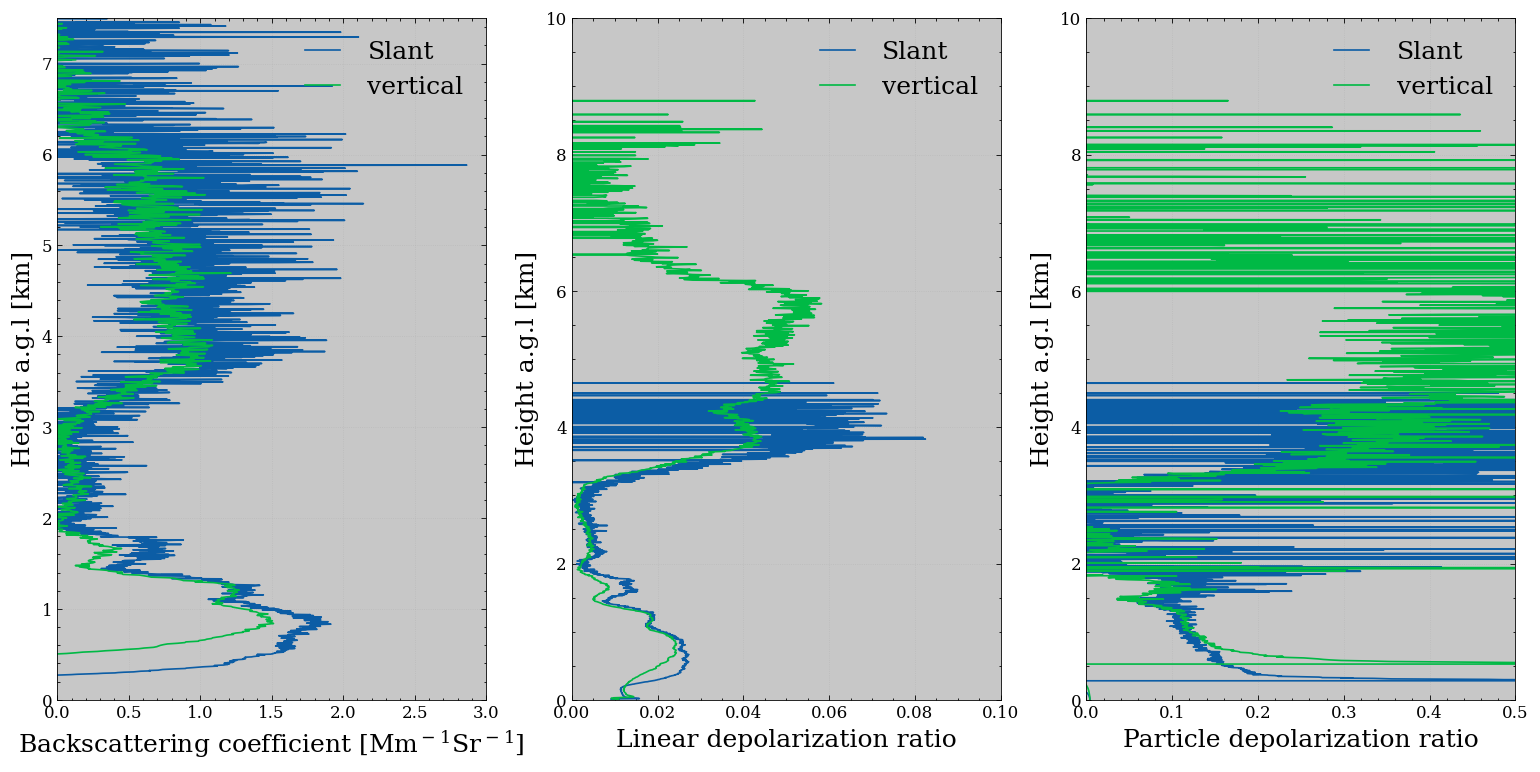

In [11]:
fig = plt.figure(figsize=(15,8),dpi=120)
fontdicts={'weight': 'bold', 'size': 15}
with plt.style.context(['science','no-latex']):
    ax = fig.add_subplot(131)
    
    ax.plot(beta_part['sla'][0:2000]*1e6,height[0:2000]/2000, label='Slant') 
    ax.plot(beta_part['ver'][0:1000]*1e6,height[0:1000]/1000,label='vertical') 

    ax.legend(fontsize=15)
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 7.5])
    ax.set_ylabel('Height a.g.l [km]',fontdict={'weight': 'normal', 'size': 15})
    ax.set_xlabel('Backscattering coefficient [M$\mathregular{m^-}$$\mathregular{^1}$$\mathregular{Sr^-}$$\mathregular{^1}$]',fontdict={'weight': 'normal', 'size': 15})
    ax.grid(True)
    
    ax = fig.add_subplot(132)

    ax.plot(lvd['sla'],height/2000, label='Slant') 
    ax.plot(lvd['ver'],height/1000,label='vertical') 

    ax.legend(fontsize=15)
    ax.set_xlim([0, 0.1])
    ax.set_ylim([0, 10])
    ax.set_ylabel('Height a.g.l [km]',fontdict={'weight': 'normal', 'size': 15})
    ax.set_xlabel('Linear depolarization ratio',fontdict={'weight': 'normal', 'size': 15})
    ax.grid(True)
    
    ax = fig.add_subplot(133)

    ax.plot(pdl['sla'][0:1333],height[0:1333]/2000, label='Slant') 
    ax.plot(pdl['ver'][0:1333],height[0:1333]/1000,label='vertical') 

    ax.legend(fontsize=15)
    ax.set_xlim([0, 0.5])
    ax.set_ylim([0, 10])
    ax.set_ylabel('Height a.g.l [km]',fontdict={'weight': 'normal', 'size': 15})
    ax.set_xlabel('Particle depolarization ratio',fontdict={'weight': 'normal', 'size': 15})
    ax.grid(True)

In [31]:
# Raman Retrieval 
rcs_387xtp_v = dsd['ver'].signal_387xtp.mean('time')*dsd['ver'].range**2
rcs_387xtp_s = dsd['sla'].signal_387xtp.mean('time')*(dsd['sla'].range*2)**2

rcs_387xta_v = dsd['ver'].signal_387xta.mean('time')*dsd['ver'].range**2
rcs_387xta_s = dsd['sla'].signal_387xta.mean('time')*(dsd['sla'].range*2)**2

rcs_387xtp_v_smooth =window_fliter(rcs_387xtp_v.values,name='Hamming', N=41)
rcs_387xtp_s_smooth =window_fliter(rcs_387xtp_s.values,name='Hamming', N=81)

rcs_387xta_v_smooth =window_fliter(rcs_387xta_v.values,name='Hamming', N=41)
rcs_387xta_s_smooth =window_fliter(rcs_387xta_s.values,name='Hamming', N=81)

alpha_raman = {'verp':[], 'slap':[],'vera':[], 'slaa':[]}

alpha_raman['verp'] = raman_retrievals.raman_extinction(rcs_387xtp_v_smooth,7.5,355,387,1,
                                                 temperature_prf['ver'],pressure_prf['ver'],21,6)

alpha_raman['slap'] = raman_retrievals.raman_extinction(rcs_387xtp_s_smooth,7.5,355,387,1,
                                                 temperature_prf['sla'],pressure_prf['sla'],21,6)

alpha_raman['vera'] = raman_retrievals.raman_extinction(rcs_387xta_v_smooth,7.5,355,387,1,
                                                 temperature_prf['ver'],pressure_prf['ver'],21,6)

alpha_raman['slaa'] = raman_retrievals.raman_extinction(rcs_387xta_s_smooth,7.5,355,387,1,
                                                 temperature_prf['sla'],pressure_prf['sla'],21,6)

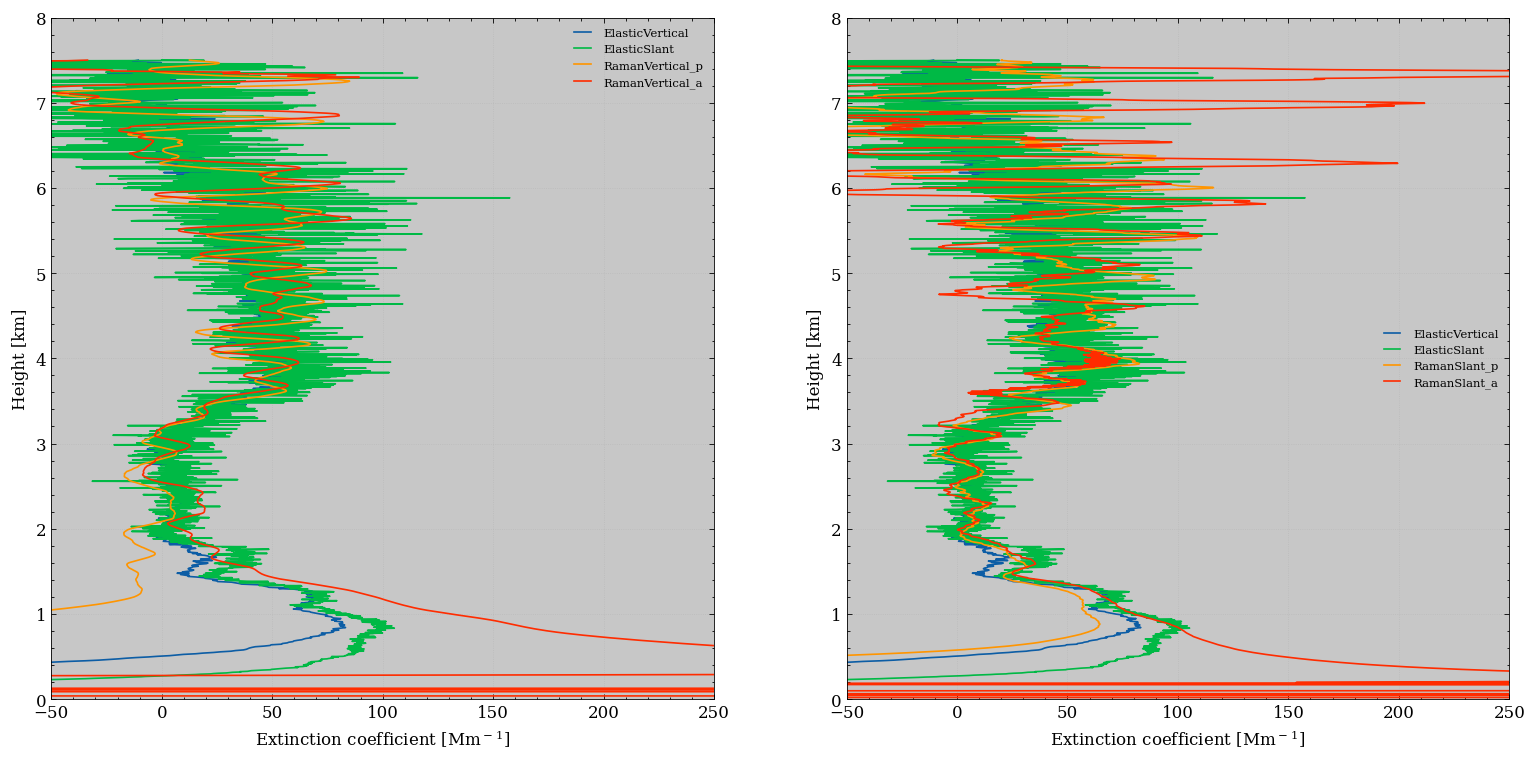

In [25]:
with plt.style.context(['science','no-latex']):
    fig = plt.figure(figsize=(15,8),dpi=120)
    ax = fig.add_subplot(121)
    ax.plot(beta_part['ver'][0:1000]*1e6*55,height[0:1000]/1000,label='ElasticVertical') 
    ax.plot(beta_part['sla'][0:2000]*1e6*55,height[0:2000]/2000,label='ElasticSlant') 
    ax.plot(alpha_raman['verp'][0:1000]*1e6,height[0:1000]/1000,label='RamanVertical_p') 
#     ax.plot(Alpha['slap'][0:2000]*1e6,height[0:2000]/2000,label='RamanSlant_p') 
    ax.plot(alpha_raman['vera'][0:1000]*1e6,height[0:1000]/1000,label='RamanVertical_a') 
#     ax.plot(Alpha['slaa'][0:2000]*1e6,height[0:2000]/2000,label='RamanSlant_a') 
    ax.legend()
    ax.set_xlim([-50, 250])
    ax.set_ylim([0, 8])
    ax.set(xlabel='Extinction coefficient [M$\mathregular{m^-}$$\mathregular{^1}$]')
    ax.set(ylabel='Height [km]')  
    ax.grid(True)
    ax = fig.add_subplot(122)
    ax.plot(beta_part['ver'][0:1000]*1e6*55,height[0:1000]/1000,label='ElasticVertical') 
    ax.plot(beta_part['sla'][0:2000]*1e6*55,height[0:2000]/2000,label='ElasticSlant') 
#     ax.plot(Alpha['verp'][0:1000]*1e6,height[0:1000]/1000,label='RamanVertical_p') 
    ax.plot(alpha_raman['slap'][0:2000]*1e6,height[0:2000]/2000,label='RamanSlant_p') 
#     ax.plot(Alpha['vera'][0:1000]*1e6,height[0:1000]/1000,label='RamanVertical_a') 
    ax.plot(alpha_raman['slaa'][0:2000]*1e6,height[0:2000]/2000,label='RamanSlant_a') 
    ax.legend()
    ax.set_xlim([-50, 250])
    ax.set_ylim([0, 8])
    ax.set(xlabel='Extinction coefficient [M$\mathregular{m^-}$$\mathregular{^1}$]')
    ax.set(ylabel='Height [km]')  
    ax.grid(True)

In [46]:
beta_raman = {'verp':[], 'slap':[],'vera':[], 'slaa':[]}
beta_part['ver']=np.where(beta_part['ver'] > 0, beta_part['ver'], 0)


beta_raman['verp'] = raman_retrievals.raman_backscatter(rcs_387xtp_v_smooth[0:2000],rcs_355xpp_v.values[0:2000],
                                               1000,7.5,molbeta['ver'][0:2000],
                                               beta_part['ver'][0:2000],
                                               355,387,1,pressure_prf['ver'][0:2000],
                                               temperature_prf['ver'][0:2000])

beta_raman['vera'] = raman_retrievals.raman_backscatter(rcs_387xta_v_smooth[0:2000],rcs_355xpp_v.values[0:2000],
                                               1000,7.5,molbeta['ver'][0:2000],
                                               beta_part['ver'][0:2000],
                                               355,387,1,pressure_prf['ver'][0:2000],
                                               temperature_prf['ver'][0:2000])


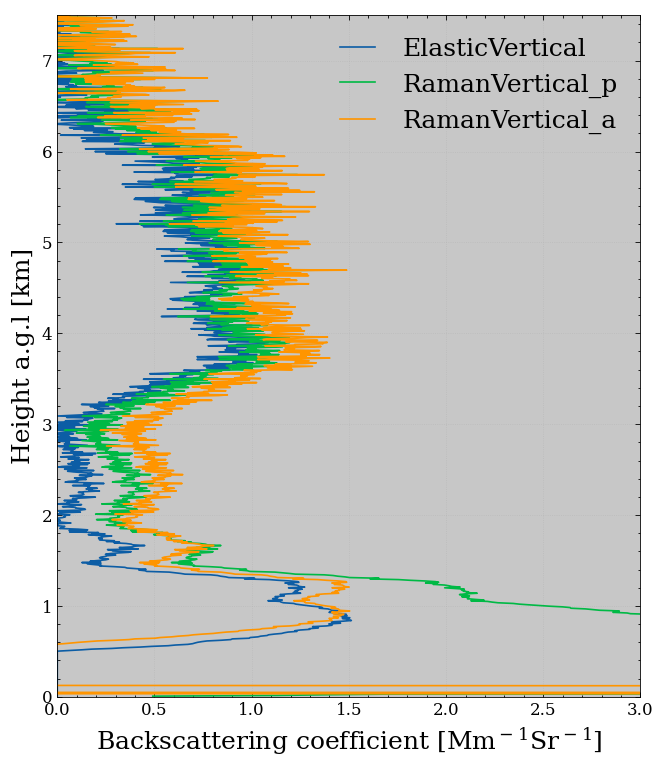

In [49]:
fig = plt.figure(figsize=(6,8),dpi=120)
fontdicts={'weight': 'bold', 'size': 15}
with plt.style.context(['science','no-latex']):
    ax = fig.add_subplot(111)
    
#     ax.plot(beta_part['sla'][0:2000]*1e6,height[0:2000]/2000, label='Slant') 
    ax.plot(beta_part['ver'][0:1000]*1e6,height[0:1000]/1000,label='ElasticVertical') 
    ax.plot(beta_raman['verp'][0:1000]*1e6,height[0:1000]/1000,label='RamanVertical_p')
    ax.plot(beta_raman['vera'][0:1000]*1e6,height[0:1000]/1000,label='RamanVertical_a') 



    ax.legend(fontsize=15)
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 7.5])
    ax.set_ylabel('Height a.g.l [km]',fontdict={'weight': 'normal', 'size': 15})
    ax.set_xlabel('Backscattering coefficient [M$\mathregular{m^-}$$\mathregular{^1}$$\mathregular{Sr^-}$$\mathregular{^1}$]',fontdict={'weight': 'normal', 'size': 15})
    ax.grid(True)